In [1]:
! ls localmz_N* >regional_mz_fft.txt

In [98]:
!cat regional_mz_fft.txt

localmz_N8_J_0.6366197723675814.hdf5
localmz_N10_J_0.6366197723675814.hdf5
localmz_N12_J_0.6366197723675814.hdf5



 localmz_N8_J_0.6366197723675814.hdf5 0
N= 8
beta= 0.0 beat_freq- 0.4
beta= 1.5 beat_freq- 0.9999999999999999
beta= 2.5 beat_freq- 1.1
beta= inf beat_freq- 1.0

 localmz_N10_J_0.6366197723675814.hdf5 1
N= 10
beta= 0.0 beat_freq- 0.45
beta= 1.5 beat_freq- 0.9999999999999999
beta= 2.5 beat_freq- 1.0499999999999998
beta= inf beat_freq- 1.0

 localmz_N12_J_0.6366197723675814.hdf5 2
N= 12
beta= 0.0 beat_freq- 0.6
beta= 1.5 beat_freq- 1.15
beta= 2.5 beat_freq- 0.95
beta= inf beat_freq- 1.0


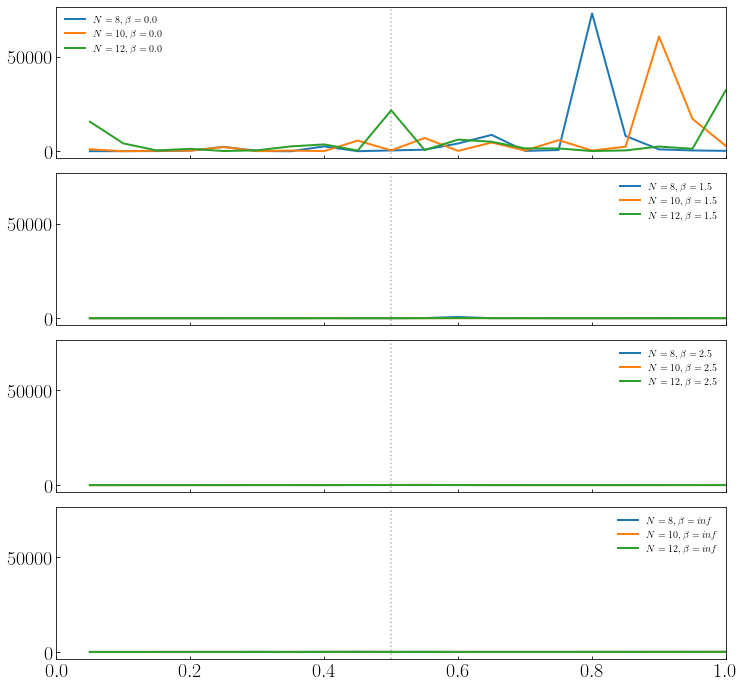

In [84]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks
from lmfit.models import LinearModel

plt.rcParams.update({"figure.figsize": (12, 12),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 20,"font.sans-serif": ["Helvetica"]})

steps = 20001
freq_threshold = 0.3

fig, axs = plt.subplots(4, 1, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.1)
Ns = []


with open("regional_mz_fft.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    btfr = np.zeros((4,x))
    
    for xx in range(0,x):
        filename = lines[xx][:-1]
        print('\n',filename, xx)
        
        with h5py.File(filename, "r") as f:
            datas = f['mz'][()]
            times = f['times'][()]
            betas = f['betas'][()]
            N = f.attrs['N']
            Jvalue = f.attrs['Jvalue']         

        omega = 20.0
        w = omega
        T = 2 * np.pi/w
        
        print('N=', N)
        for b, beta in enumerate(betas):
            
            datap = np.zeros((N, len(times)))
            for i in range(N):
                datap[i] = datas[b][i][0]
                
            mz_dt = [datap[m] for m in range(int(N/2),N)]
            mz_data = np.sum(mz_dt, axis=0) * 2/N
            
            frequencies = np.fft.fftfreq(mz_data.size, d = 1/steps)
            fft_values = np.fft.fft(mz_data - np.average(mz_data))
            
            mask = frequencies > freq_threshold
            y = np.abs(fft_values[mask])**2
            x = frequencies[mask]
            
            line, = axs[b].plot(x/w, y,linewidth=2.0,label = fr'$N={N}, \beta = {beta}$')
            axs[b].axvline(x=0.5, color = 'black', ls = 'dotted',alpha = 0.1)            
            
            peak_idx, peak_props = find_peaks(y, prominence = 0.5, distance = None)
            peak_pos = x[peak_idx]/w                     
            
            peaks_before = peak_pos[peak_pos < 0.5]
            before_proms = peak_props['prominences'][peak_pos < 0.5]
            most_prominent_idx = np.argmax(before_proms)
            prominent_freq_before = peaks_before[most_prominent_idx]

            peaks_after = peak_pos[peak_pos > 0.5]
            after_proms = peak_props['prominences'][peak_pos > 0.5]
            most_prominent_idx = np.argmax(after_proms)
            prominent_freq_after = peaks_after[most_prominent_idx]
            beat_freq = np.abs(prominent_freq_after-prominent_freq_before)
            
            print('beta=',beta,'beat_freq-',beat_freq)  
            btfr[b][xx] = beat_freq         
            
            
            axs[b].set_xlim(0,1)
            #axs[b].set_ylim(bottom = 0.1)
            axs[b].tick_params(which='both', axis="x", direction="in")
            axs[b].tick_params(which='both', axis="y", direction="in")
            
            axs[b].legend(fontsize = 10, frameon = False)
            #axs[b].set_yscale('log')
        Ns.append(N)
        
#plt.yscale('log')
#plt.legend(fontsize = 10, frameon = False)
plt.show()

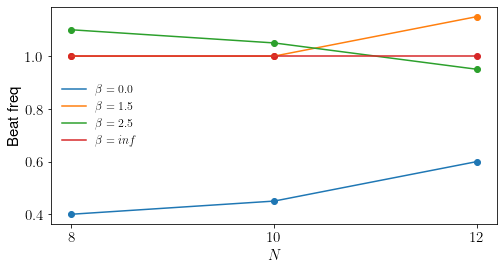

In [118]:
plt.rcParams.update({"figure.figsize": (8, 4),\
                     "text.usetex": True,"font.family": "sans-serif",\
                     "font.size": 15,"font.sans-serif": ["Helvetica"]})

for i in range(4):
    beta = betas[i]
    plt.plot(Ns, btfr[i], label = fr"$\beta = {beta}$")
    plt.scatter(Ns, btfr[i])
    
plt.xticks([8,10,12])
plt.xlabel(r"$N$")    
plt.ylabel("Beat freq") 

plt.legend(frameon =False, loc = 6, fontsize = 12)    
plt.show()